In [1]:
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1

2023-04-04 15:01:15.581559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-04-04 15:01:17.758477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-04 15:01:17.790867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-04 15:01:17.791079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
L = 2
n = 4
k = (n * np.pi) / L
E = 0.5 * (k ** 2)

In [14]:
print(k)
print(E)

6.283185307179586
19.739208802178716


In [15]:
domain = dde.geometry.Interval(-L / 2, L / 2)

In [16]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return 0.5 * dy_xx + E * y

In [17]:
def psi(x):
    normalization_constant = np.sqrt(2.0 / L)
    return normalization_constant * np.sin(k * (x + 0.5 * L))

In [18]:
collocation_points = np.array([(5/13) * L, -(5/13) * L]).reshape((2, 1))
collocation_values = psi(collocation_points)
print(collocation_values)
ic = dde.icbc.PointSetBC(collocation_points, collocation_values)

[[-0.99270887]
 [ 0.99270887]]


In [19]:
data = dde.data.PDE(domain, pde, ic, 16, solution=psi, num_test=100)

In [20]:
layer_size = [1] + [20] * 5 + [1]
activation = 'tanh'
initializer = 'Glorot uniform'
net = dde.nn.FNN(layer_size, activation, initializer)

In [21]:
model = dde.Model(data, net)
model.compile('adam', lr=0.001, metrics=['l2 relative error'])

Compiling model...
Building feed-forward neural network...
'build' took 0.074032 s



2023-04-04 15:02:44.331114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-04 15:02:44.331448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-04 15:02:44.331702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

'compile' took 0.680354 s



In [22]:
loss_history, train_state = model.train(iterations=10000)
# check callbacks in the tutorial

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [1.07e+00, 1.13e+00]    [1.06e+00, 1.13e+00]    [1.03e+00]    
1000      [5.17e-03, 9.74e-01]    [5.28e-03, 9.74e-01]    [9.98e-01]    
2000      [1.72e-02, 9.34e-01]    [1.67e-02, 9.34e-01]    [9.76e-01]    
3000      [4.22e-02, 6.17e-01]    [5.95e-02, 6.17e-01]    [7.94e-01]    
4000      [2.67e-03, 4.24e-02]    [5.42e+00, 4.24e-02]    [2.48e-01]    
5000      [8.03e-05, 3.49e-04]    [1.53e+01, 3.49e-04]    [1.72e-01]    
6000      [1.55e-03, 1.66e-04]    [1.31e+01, 1.66e-04]    [1.52e-01]    
7000      [1.61e-05, 3.27e-05]    [1.23e+01, 3.27e-05]    [1.42e-01]    
8000      [8.67e-05, 5.86e-05]    [1.09e+01, 5.86e-05]    [1.31e-01]    
9000      [2.18e-03, 4.51e-05]    [9.95e+00, 4.51e-05]    [1.25e-01]    
10000     [1.49e-02, 1.18e-05]    [9.70e+00, 1.18e-05]    [1.22e-01]    

Best model at step 7000:
  train loss: 4.88e-05
  test loss: 1.23e+01
  test m

Saving loss history to /home/piotr/repos/quant-chem-pinns/loss.dat ...
Saving training data to /home/piotr/repos/quant-chem-pinns/train.dat ...
Saving test data to /home/piotr/repos/quant-chem-pinns/test.dat ...


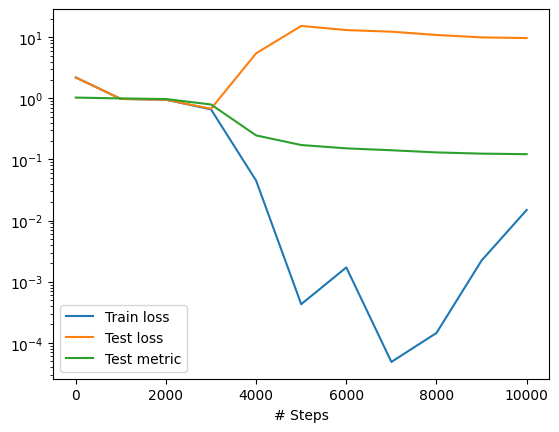

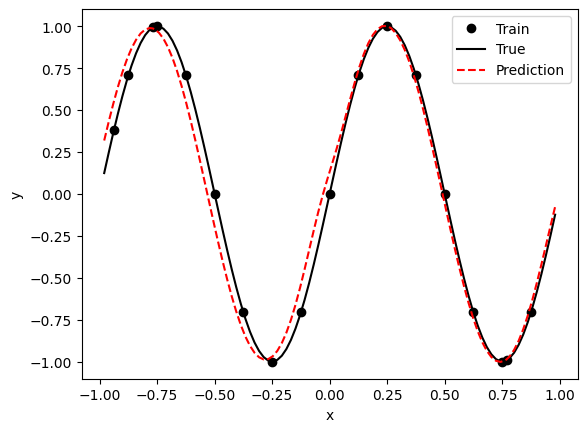

In [23]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)